## Table of contents:
* [The main purpose](#first-bullet)
* [Importing necessary modules](#second-bullet)
* [Exploring data](#third-bullet)
* [Features extraction](#featuresextraction)
* [Data visualization](#datavisualization)
* [Modeling](#modeling)
* [Conclusions](#conclusions)

## Questions:
* [Do customers in different regions spend more per transaction? Which regions spend the most/least?](#Q1)
* [Is there a relationship between the number of items purchased and amount spent?](#Q2)
* [Are there differences in the age of customers between regions?](#Q3)
* [If so, can we predict the age of a customer in a region based on other demographic data?](#Q4)
* [Is there any correlation between age of a customer and if the transaction was made online or in the store? Do any other factors predict if a customer will buy online or in our stores?](#Q5)
* [What about items? Are these even in the tree? Why or why not??](#Q6)

# The main purpose <a class="anchor" id="first-bullet"></a>

The main purpose of these analyzes is to understand and discover the behavior of customers in online and in-store shopping from different regions. One of the tasks set by the client was age prediction based on the region. Another dependence that played a large role for the customer and understanding the behavior of buyers was the prediction whether the customer will buy the product online or in the store based on the collected demographic data.

# Importing necessary modules <a class="anchor" id="second-bullet"></a>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline


#Machine learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn import tree

import xgboost as xgb



# Exploring data <a class="anchor" id="third-bullet"></a>

In [31]:
data = pd.read_csv('Demographic_Data.csv')

#### The dataset contains 80,000 records and five columns:
#### a) in-store - the bool value determines whether the purchase was made online or in-store 
#### b) age - the age of the client (min 18 max 85)
#### c) items - number of items purchased (min 1 max 8)
#### d) amout - amount paid (min 5.0047 max 3000) 
#### e) region - a categorical, nominal variable specifies one of 4 regions (North, South, East, West) 

In [32]:
data = data.drop_duplicates()

### 21 duplicates were removed from the dataset. I decided to remove all duplicates, because the amount of duplicates were not high and indexes of transactions were different (not in sequence). Dataset do not contain missing values.

# Features extraction <a class="anchor" id="featuresextraction"></a>

Age rounded to nearest tenth

In [33]:
data['age_round'] = ((data['age']/10).round()*10).astype(int)

Amount spend per item

In [34]:
data['amount_per_item'] = data['amount']/data['items']

Counting people in each age group (every 10 years).

In [35]:
age_counts = data['age_round'].value_counts().sort_index()

Features discretization

In [67]:
data['age_levels']=pd.cut(data['age'],3,labels=['Young','Middle','Old'])
print('Mean of ages in groups:\n', data['age'].groupby(data['age_levels']).mean())
print('Minimum of ages in groups:\n', data['age'].groupby(data['age_levels']).min())
print('Maximum of ages in groups:\n', data['age'].groupby(data['age_levels']).max())
print('Count of ages in groups:\n', data['age'].groupby(data['age_levels']).count())
young_mean = round(data['age'].groupby(data['age_levels']).mean()['Young'])
middle_mean = round(data['age'].groupby(data['age_levels']).mean()['Middle'])
old_mean = round(data['age'].groupby(data['age_levels']).mean()['Old'])

data.loc[data['age_levels']=='Young', 'age_levels_mean'] = young_mean
data.loc[data['age_levels']=='Middle', 'age_levels_mean'] = middle_mean
data.loc[data['age_levels']=='Old', 'age_levels_mean'] = old_mean

Mean of ages in groups:
 age_levels
Young     30.696913
Middle    50.602622
Old       71.654716
Name: age, dtype: float64
Minimum of ages in groups:
 age_levels
Young     18
Middle    41
Old       63
Name: age, dtype: int64
Maximum of ages in groups:
 age_levels
Young     40
Middle    62
Old       85
Name: age, dtype: int64
Count of ages in groups:
 age_levels
Young     32885
Middle    34403
Old       12691
Name: age, dtype: int64


In [37]:
data['age_levels_5']=pd.cut(data['age'],5,labels=['Age1', 'Age2', 'Age3', 'Age4', 'Age5'])
data.loc[data['age_levels_5']=='Age1', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age1'])
data.loc[data['age_levels_5']=='Age2', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age2'])
data.loc[data['age_levels_5']=='Age3', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age3'])
data.loc[data['age_levels_5']=='Age4', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age4'])
data.loc[data['age_levels_5']=='Age5', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age5'])

data['amount_levels_5']=pd.cut(data['amount'],5,labels=['Amount1', 'Amount2', 'Amount3', 'Amount4', 'Amount5'])
data.loc[data['amount_levels_5']=='Amount1', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount1'])
data.loc[data['amount_levels_5']=='Amount2', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount2'])
data.loc[data['amount_levels_5']=='Amount3', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount3'])
data.loc[data['amount_levels_5']=='Amount4', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount4'])
data.loc[data['amount_levels_5']=='Amount5', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount5'])

data['amount_normalized']=(data['amount']-data['amount'].mean())/data['amount'].std()

data1 = pd.get_dummies(data['region'], prefix='Region', drop_first=True)
data = pd.concat([data, data1], axis=1)

# Data visualization  <a class="anchor" id="datavisualization"></a>

## Simple visualization of data <a class="anchor" id="fifth-a-bullet"></a>

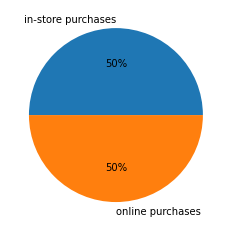

In [38]:
labels = ["in-store purchases", "online purchases"]
plt.pie([data[data['in-store']==1]['in-store'].count(), data[data['in-store']==0]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.show()

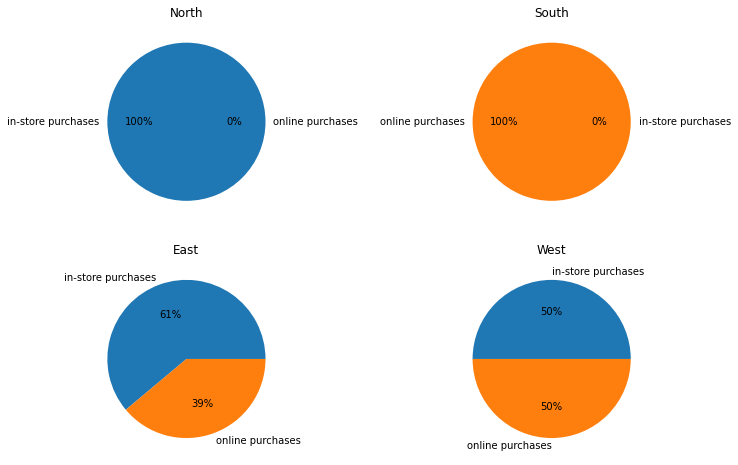

In [39]:
labels = ["in-store purchases", "online purchases"]
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.pie([data[(data['in-store']==1)&(data['region']==1)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==1)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("North")
plt.subplot(2, 2, 2)
plt.pie([data[(data['in-store']==1)&(data['region']==2)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==2)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("South")
plt.subplot(2, 2, 3)
plt.pie([data[(data['in-store']==1)&(data['region']==3)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==3)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("East")
plt.subplot(2, 2, 4)
plt.pie([data[(data['in-store']==1)&(data['region']==4)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==4)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("West")
plt.show()

### North customers buy only in-store, South customers buy only online. More than 60% of East customers buy instore. Half of West customers buy online.

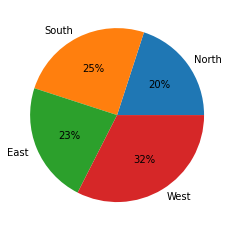

In [40]:
labels = ["North", "South", "East", "West"]

plt.pie([data[data['region']==1]['region'].count(), data[data['region']==2]['region'].count(), data[data['region']==3]['region'].count(), data[data['region']==4]['region'].count()], labels=labels, autopct='%1.0f%%')
plt.show()

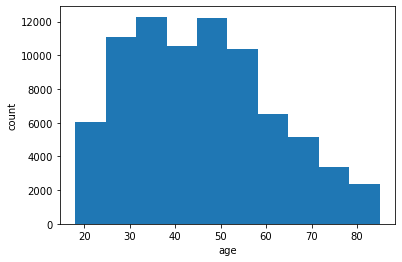

In [41]:
plt.hist(data['age'])
plt.xlabel('age')
plt.ylabel('count')
plt.show()

### Age data histogram is Positively (Right) Skewed. 

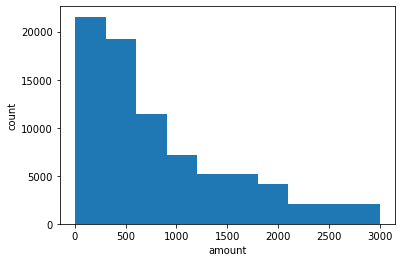

In [42]:
plt.hist(data['amount'])
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

### Most often, less than 750 were spend when shopping.

# Do customers in different regions spend more per transaction? Which regions spend the most/least? <a class="anchor" id="Q1"></a>

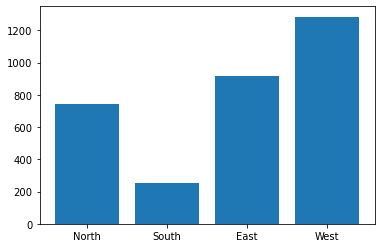

In [43]:
labels = ["North", "South", "East", "West"]
plt.bar(labels,data['amount'].groupby(data['region']).sum()/data['region'].groupby(data['region']).count())
plt.show()

### The bar plot shows that customers from West spend the most per transaction and customers from South spend the least per transaction

# Is there a relationship between the number of items purchased and amount spent?  <a class="anchor" id="Q2"></a>

In [44]:
data.corr('pearson')

,in-store,age,items,amount,region,age_round,amount_per_item,age_levels_5_mean,amount_levels_5_mean,amount_normalized,Region_2,Region_3,Region_4
in-store,1.000000,-0.178180,-0.003897,-0.085573,-0.133171,-0.180490,-0.054597,-0.177309,-0.093203,-0.085573,-0.577343,0.119691,-0.000009
age,-0.178180,1.000000,0.000657,-0.282033,-0.235370,0.983693,-0.187250,0.970109,-0.273884,-0.282033,0.398625,-0.003826,-0.309304
items,-0.003897,0.000657,1.000000,0.000384,-0.001904,0.000210,-0.469112,0.000801,0.000434,0.000384,0.002149,-0.002911,-0.000458
amount,-0.085573,-0.282033,0.000384,1.000000,0.403486,-0.276769,0.666868,-0.267094,0.974794,1.000000,-0.467248,0.061376,0.431044
region,-0.133171,-0.235370,-0.001904,0.403486,1.000000,-0.231827,0.269473,-0.222032,0.393620,0.403486,-0.345855,0.155499,0.815993
age_round,-0.180490,0.983693,0.000210,-0.276769,-0.231827,1.000000,-0.183685,0.952719,-0.268681,-0.276769,0.393874,-0.001191,-0.306566
amount_per_item,-0.054597,-0.187250,-0.469112,0.666868,0.269473,-0.183685,1.000000,-0.178386,0.649674,0.666868,-0.311520,0.040389,0.288070
age_levels_5_mean,-0.177309,0.970109,0.000801,-0.267094,-0.222032,0.952719,-0.178386,1.000000,-0.259223,-0.267094,0.383516,-0.004165,-0.293751
amount_levels_5_mean,-0.093203,-0.273884,0.000434,0.974794,0.393620,-0.268681,0.649674,-0.259223,1.000000,0.974794,-0.446413,0.055100,0.420443
amount_normalized,-0.085573,-0.282033,0.000384,1.000000,0.403486,-0.276769,0.666868,-0.267094,0.974794,1.000000,-0.467248,0.061376,0.431044


### There are no Pearson correlation between items and amount, but there are observed correlation (not very strong) between age - in-store, region - items, region - age. There are no Spearman correlation between items and amount, but there are observed correlation (not very strong) between age - in-store, region - items, region - age.

## Checking dependency between amount and items purchased online and in-store

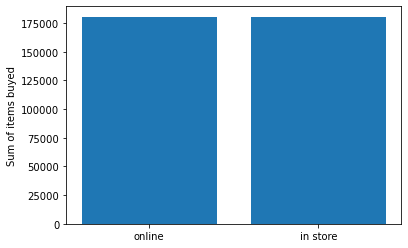

In [45]:
plt.bar(['online', 'in store'],data['items'].groupby(data['in-store']).sum())
plt.ylabel('Sum of items buyed')
plt.show()

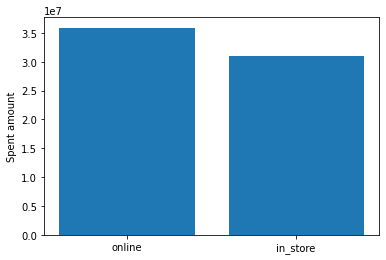

In [46]:
plt.bar(['online', 'in_store'],data['amount'].groupby(data['in-store']).sum())
plt.ylabel('Spent amount')
plt.show()

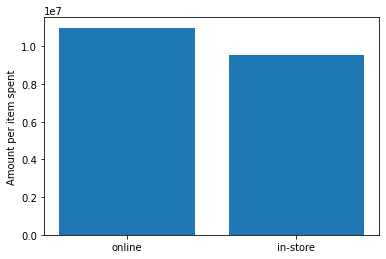

In [47]:
plt.bar(['online', 'in-store'],data['amount_per_item'].groupby(data['in-store']).sum())
plt.ylabel('Amount per item spent')
plt.show()

### Total number of items purchased online is same as total number of items purchased online, but customers spend more money during online shoping, because they choose more expensive products than in in-store shopping.

## Checking dependency between age and items, amount and amount per item

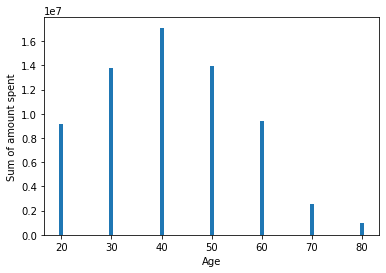

In [48]:
plt.bar(data['amount'].groupby(data['age_round']).sum().index, data['amount'].groupby(data['age_round']).sum().values)
plt.xlabel('Age')
plt.ylabel('Sum of amount spent')
plt.show()

### The bar plots shows that distribution beetween three selected dependencies (sum of amount spent, sum of item bought, sum of amount per item) does not change. Due to the unequal size of age groups, further analyzes are needed, especially taking into account the value per person.

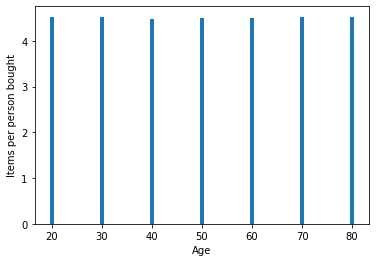

In [49]:
plt.bar(data['items'].groupby(data['age_round']).sum().index, data['items'].groupby(data['age_round']).sum().values/age_counts.values)
plt.xlabel('Age')
plt.ylabel('Items per person bought')
plt.show()

### In each age group, customers buy on average the same number of products per person.

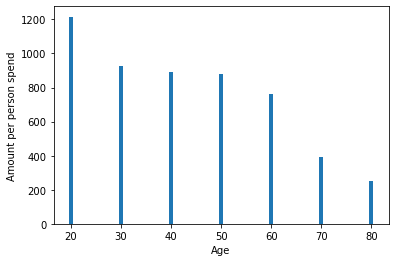

In [50]:
plt.bar(data['amount'].groupby(data['age_round']).sum().index, data['amount'].groupby(data['age_round']).sum().values/age_counts.values)
plt.xlabel('Age')
plt.ylabel('Amount per person spend')
plt.show()

### The bar plot shows that younger people spend in average more money

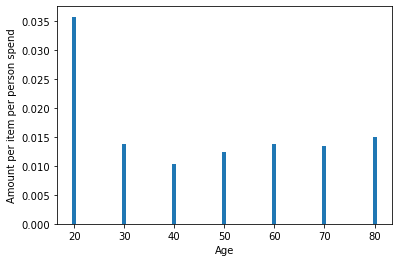

In [51]:
plt.bar(data['amount'].groupby(data['age_round']).sum().index, data['amount'].groupby(data['age_round']).sum().values/data['items'].groupby(data['age_round']).sum().values/age_counts.values)
plt.xlabel('Age')
plt.ylabel('Amount per item per person spend')
plt.show()

### The bar plot shows that younger people spend in average more money per item.

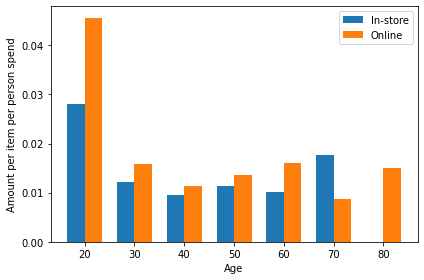

In [52]:
instore = data['amount'][data['in-store']==True].groupby(data['age_round']).sum().index, data['amount'][data['in-store']==True].groupby(data['age_round']).sum().values/data['items'][data['in-store']==True].groupby(data['age_round']).sum().values/age_counts.values[:-1]
online = data['amount'][data['in-store']==False].groupby(data['age_round']).sum().index, data['amount'][data['in-store']==False].groupby(data['age_round']).sum().values/data['items'][data['in-store']==False].groupby(data['age_round']).sum().values/age_counts.values
labels = age_counts.index
x_instore = np.arange(len(labels[:-1]))
x_online = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_instore - width/2, instore[1], width, label='In-store')
rects2 = ax.bar(x_online + width/2, online[1], width, label='Online')

ax.set_ylabel('Amount per item per person spend')
ax.set_xlabel('Age')
ax.set_xticks(x_online)
ax.set_xticklabels(labels.astype(int))
ax.legend()

fig.tight_layout()

plt.show()

### Presented graph shows that:
### a) People older than 80 years old do not buy in-store
### b) Only people in their seventies bought more expensive products in-store than online
### c) People from 30-60 years old spend more less the same in-store and online per one product
### d) Youngest people spend more per item online than in-store

## Comparision of amount spend in-store and onlne by East and West customers (North and South customers are skipped because they choose only one method of buying)

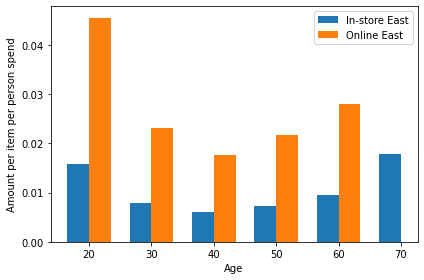

In [53]:
instore_reg3 = data['amount'][(data['in-store']==True)&(data['region']==3)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==True)&(data['region']==3)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==True)&(data['region']==3)].groupby(data['age_round']).sum().values/age_counts.values[:-1]
online_reg3 = data['amount'][(data['in-store']==False)&(data['region']==3)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==False)&(data['region']==3)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==False)&(data['region']==3)].groupby(data['age_round']).sum().values/age_counts.values[:-2]
labels = age_counts.index
x_instore = np.arange(len(labels[:-1]))
x_online = np.arange(len(labels[:-2]))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_instore - width/2, instore_reg3[1], width, label='In-store East')
rects2 = ax.bar(x_online + width/2, online_reg3[1], width, label='Online East')

ax.set_ylabel('Amount per item per person spend')
ax.set_xlabel('Age')
ax.set_xticks(x_instore)
ax.set_xticklabels(labels[:-1].astype(int))
ax.legend()

fig.tight_layout()

plt.show()

### People from East spend in average more amount per item online besides 70 yo people which do not buy online

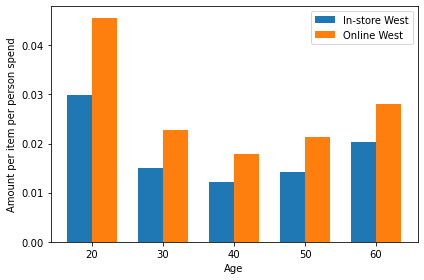

In [54]:
instore_reg3 = data['amount'][(data['in-store']==True)&(data['region']==4)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==True)&(data['region']==4)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==True)&(data['region']==4)].groupby(data['age_round']).sum().values/age_counts.values[:-2]
online_reg3 = data['amount'][(data['in-store']==False)&(data['region']==4)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==False)&(data['region']==4)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==False)&(data['region']==4)].groupby(data['age_round']).sum().values/age_counts.values[:-2]
labels = age_counts.index[:-2]
x_instore = np.arange(len(labels))
x_online = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_instore - width/2, instore_reg3[1], width, label='In-store West')
rects2 = ax.bar(x_online + width/2, online_reg3[1], width, label='Online West')

ax.set_ylabel('Amount per item per person spend')
ax.set_xlabel('Age')
ax.set_xticks(x_instore)
ax.set_xticklabels(labels.astype(int))
ax.legend()

fig.tight_layout()

plt.show()

### People from West spend in average more amount per item online.

## Comparision of customers age in different regions

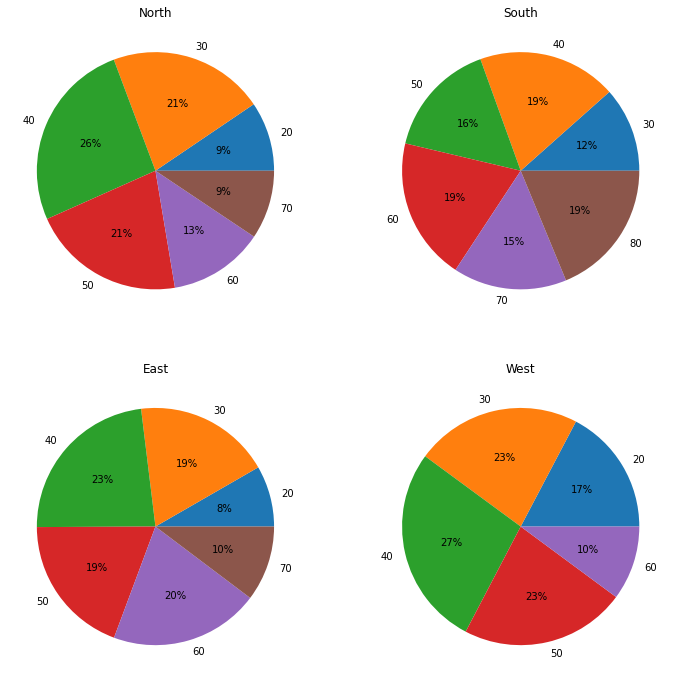

In [55]:
age_counts_north = data['age_round'][data['region']==1].value_counts().sort_index()
age_counts_south = data['age_round'][data['region']==2].value_counts().sort_index()
age_counts_east = data['age_round'][data['region']==3].value_counts().sort_index()
age_counts_west = data['age_round'][data['region']==4].value_counts().sort_index()


plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.pie(np.array(age_counts_north.values), labels=age_counts_north.index, autopct='%1.0f%%')
plt.title('North')
plt.subplot(2,2,2)
plt.pie(np.array(age_counts_south.values), labels=age_counts_south.index, autopct='%1.0f%%')
plt.title('South')
plt.subplot(2,2,3)
plt.pie(np.array(age_counts_east.values), labels=age_counts_east.index, autopct='%1.0f%%')
plt.title('East')
plt.subplot(2,2,4)
plt.pie(np.array(age_counts_west.values), labels=age_counts_west.index, autopct='%1.0f%%')
plt.title('West')
plt.show()

### There are no visible outliers. Not all regions have the same age groups.

# Are there differences in the age of customers between regions? <a class="anchor" id="Q3"></a>

### Analyzing figure above we can see that only in South there are people above 80 yo. Apart from that any differences are observed.

# Modeling - Classification <a class="anchor" id="Modeling"></a>

### I will test a lot of different models so I decided to create function to fit, predict and plot results

In [56]:
def fit_predict_plot(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [57]:
def fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X=X_train, y=y_train, cv=10, n_jobs=1)
    print('Cross Validation accuracy scores: %s' % scores)
    print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [59]:
def fit_predict_plot_GS(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels, params):
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [60]:
X = data[['region']]
y = data['age_round']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['20', '30', '40', '50', '60', '70', '80']

## Customer age prediction - 7 bins

### Decision Tree Classifier

Accuracy: 25 %
              precision    recall  f1-score   support

          20       0.00      0.00      0.00      1896
          30       0.00      0.00      0.00      3694
          40       0.26      0.81      0.40      4873
          50       0.00      0.00      0.00      3924
          60       0.19      0.32      0.24      3006
          70       0.00      0.00      0.00      1664
          80       0.00      0.00      0.00       938

    accuracy                           0.25     19995
   macro avg       0.06      0.16      0.09     19995
weighted avg       0.09      0.25      0.13     19995



C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


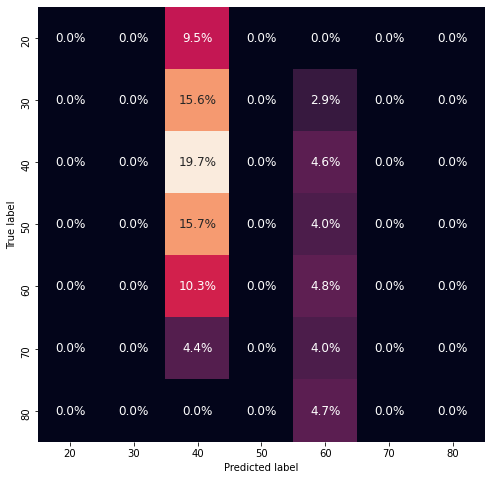

In [61]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)

## Customer age prediction - 3 bins

In [62]:
X = data[['region']]
y = data['age_levels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['Young','Middle','Old']

Accuracy: 47 %
              precision    recall  f1-score   support

      Middle       0.46      0.24      0.32      8592
         Old       0.40      0.63      0.49      3208
       Young       0.51      0.65      0.57      8195

    accuracy                           0.47     19995
   macro avg       0.46      0.51      0.46     19995
weighted avg       0.47      0.47      0.45     19995



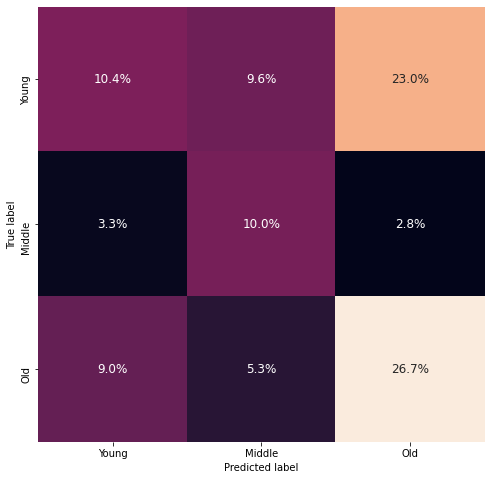

In [63]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)

### Models (Decision Tree Classifier and XGBoost Classifier) obtained bigger accuracy using less classes, but it is not sufficient to predict age using only region. An apparent increase in accuracy is expected as the number of classes is reduced. For 7 classes and random classifier, the accuracy is ~14%, while for 3 classes it increases to ~33%.

# If so, can we predict the age of a customer in a region based on other demographic data? <a class="anchor" id="Q4"></a>

### There is no clear correlation between the region and the age of the consumer. Due to this fact I decided to check if adding other data can increase performance of the model.

In [64]:
X = data[['region', 'in-store', 'amount', 'items']]
y = data['age_levels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['Young','Middle','Old']

Accuracy: 43 %
              precision    recall  f1-score   support

      Middle       0.44      0.44      0.44      8592
         Old       0.33      0.33      0.33      3208
       Young       0.46      0.45      0.46      8195

    accuracy                           0.43     19995
   macro avg       0.41      0.41      0.41     19995
weighted avg       0.43      0.43      0.43     19995



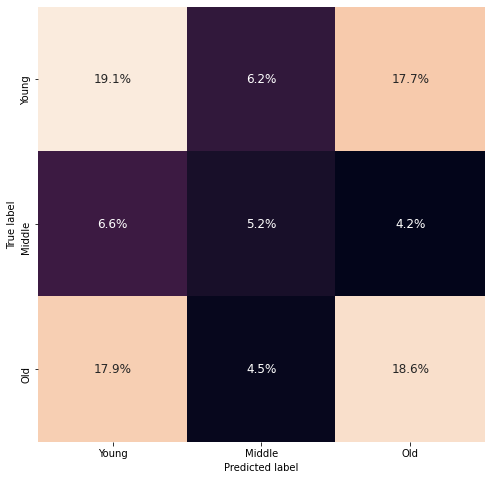

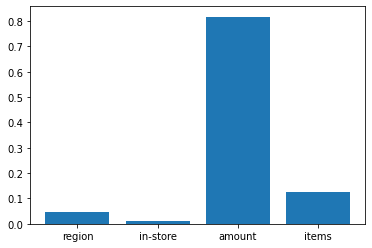

In [65]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)
plt.bar(['region', 'in-store', 'amount', 'items'],model.feature_importances_)
plt.show()

C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 47 %
              precision    recall  f1-score   support

      Middle       0.43      0.46      0.45      8592
         Old       0.39      0.33      0.36      3208
       Young       0.54      0.54      0.54      8195

    accuracy                           0.47     19995
   macro avg       0.46      0.44      0.45     19995
weighted avg       0.47      0.47      0.47     19995



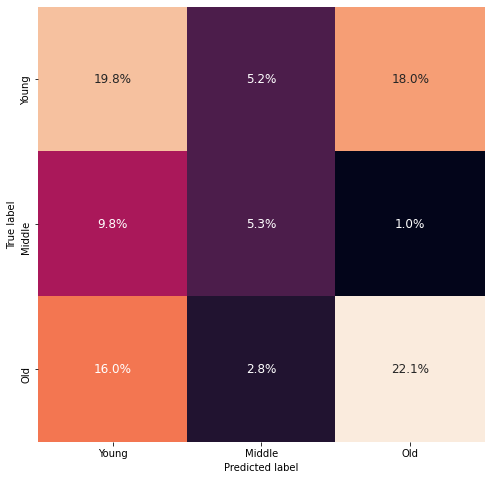

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

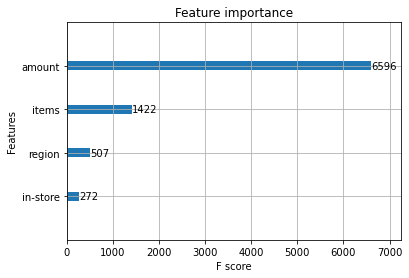

In [66]:
model = xgb.XGBClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)
xgb.plot_importance(model)

### In order to check the validity of features for the models, two charts were prepared. Both models showed that the total amount of purchases is important to predict the age, then to a much lesser extent the number of items purchased, the region and whether the purchase was made in-store or online. Analyzing the presented data, I came to the conclusion that it is not possible to predict the consumer's age on the basis of demographic data.

# Is there any correlation between age of a customer and if the transaction was made online or in the store? Do any other factors predict if a customer will buy online or in our stores? <a class="anchor" id="Q5"></a>

## Trying to predict if the transaction was made online or in the store basic on the age of the customer aggregated to seven levels 

In [72]:
X = data[['age_round']]
y = data['in-store']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
labels = ['in-store', 'online']

Accuracy: 59 %
              precision    recall  f1-score   support

           0       0.71      0.28      0.41      9870
           1       0.56      0.89      0.69     10125

    accuracy                           0.59     19995
   macro avg       0.63      0.59      0.55     19995
weighted avg       0.63      0.59      0.55     19995



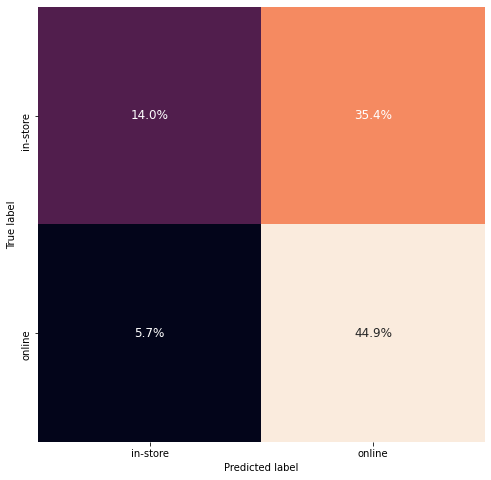

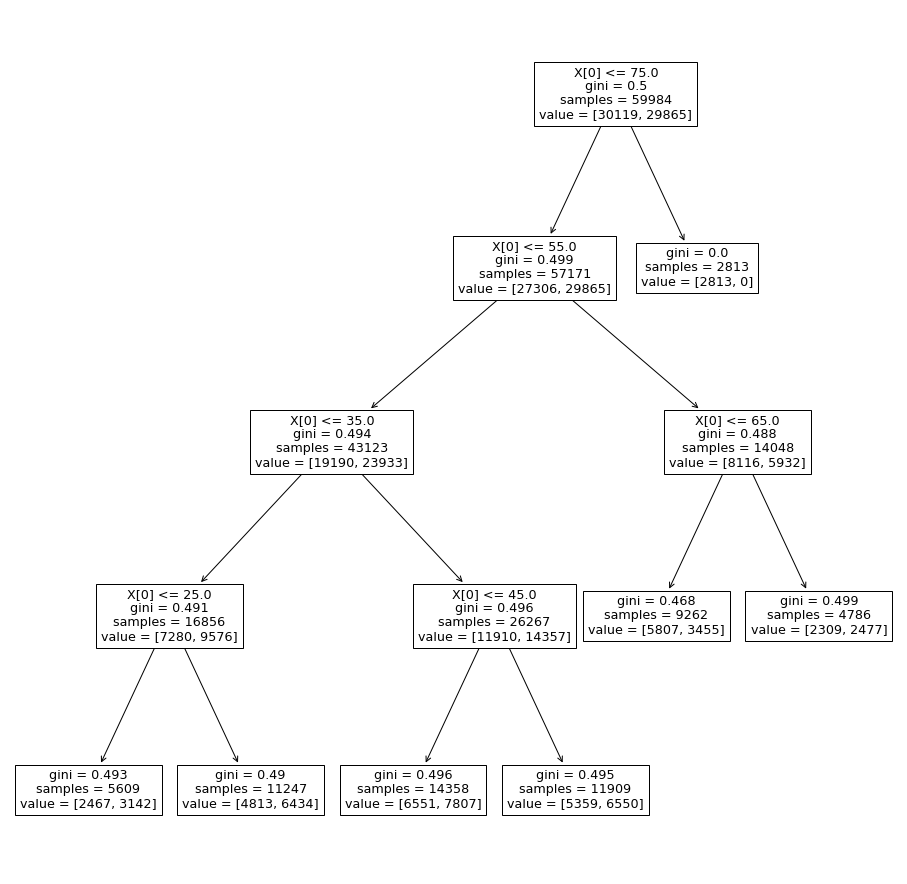

In [73]:
model = DecisionTreeClassifier(max_depth=4)
fit_predict_plot(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(16,16))
tree.plot_tree(model)
plt.show()

### The model obtained accuracy 59%. When analyzing the decision tree, it can be noticed that the model correctly recognized that people over 75 years old do not make in-store purchases. This relationship has also been shown previously in the EDA.

C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 59 %
              precision    recall  f1-score   support

           0       0.71      0.28      0.41      9870
           1       0.56      0.89      0.69     10125

    accuracy                           0.59     19995
   macro avg       0.63      0.59      0.55     19995
weighted avg       0.63      0.59      0.55     19995



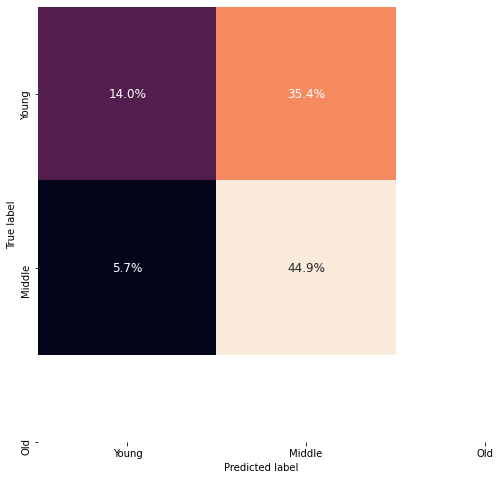

In [56]:
model = xgb.XGBClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)

### XGBoost also showed similar accuracy as decision trees. Therefore, to obtain an effective model, it is necessary to use more features. It is not possible to predict whether a customer bought online or in a store just based on his age.

## Adding new features for higher accuracy

### At the beginning, I added all the available features to check the importace of the features for the model.

In [75]:
feats = ['age', 'items', 'amount', 'region', 'age_round',
       'amount_per_item', 'age_levels_mean']
X = data[feats]
y = data['in-store']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
labels = ['in-store', 'online']

Accuracy: 84 %
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      9870
           1       0.85      0.84      0.84     10125

    accuracy                           0.84     19995
   macro avg       0.84      0.84      0.84     19995
weighted avg       0.84      0.84      0.84     19995



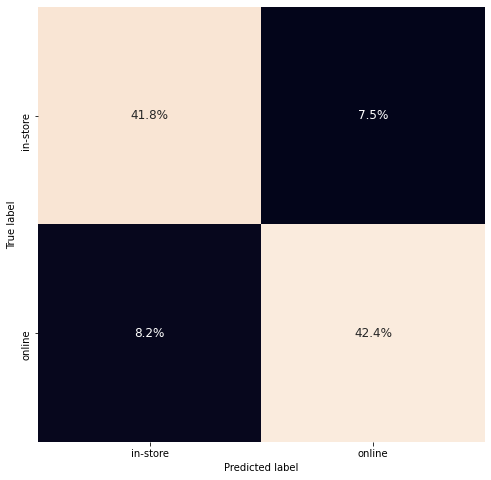

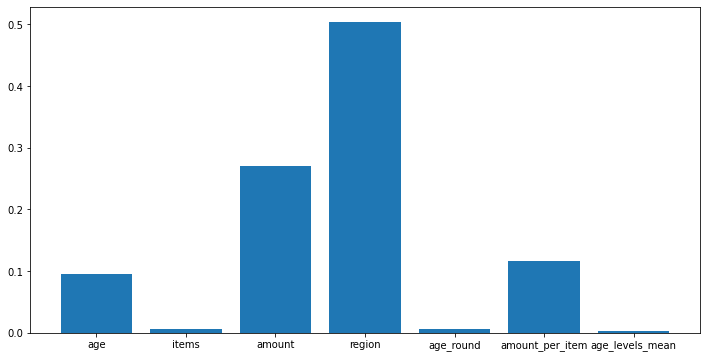

In [77]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(12,6))
plt.bar(feats,model.feature_importances_)
plt.show()

## What about items? Are these even in the tree? Why or why not? <a class="anchor" id="Q4"></a>

### Items are not in the tree and has very low importance for models due to its low correlation with target variable

C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88 %
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      9870
           1       0.82      0.98      0.90     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



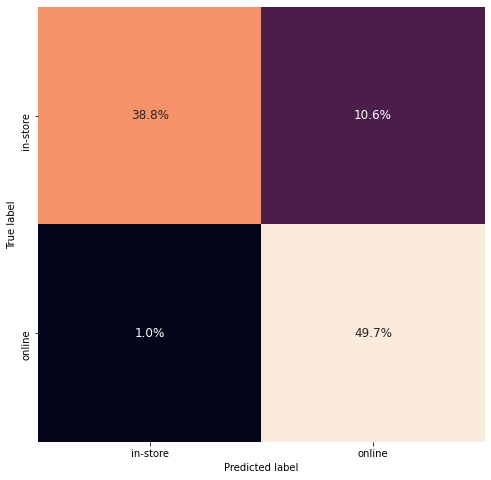

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

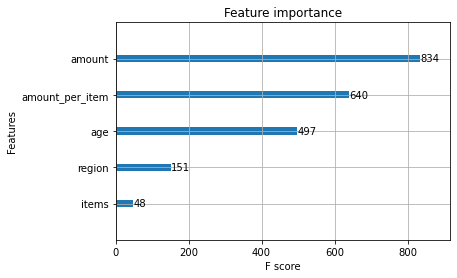

In [78]:
model = xgb.XGBClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, labels, labels)
xgb.plot_importance(model)

### Both models showed a high efficiency of over 80%. In the case of decision trees, the highest importance was given to features such as region, amount, age and amount_per_item. The Items feature is not very important for the model. For further modeling, I used features such as region, amount, age.

In [79]:
feats = ['age', 'amount', 'region']
X = data[feats]
y = data['in-store']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['in-store', 'online']

Cross Validation accuracy scores: [0.85397566 0.84547425 0.84280713 0.84914152 0.84761587 0.84978326
 0.84544848 0.84344782 0.84544848 0.84694898]
Cross Validation accuracy: 0.847 +/- 0.003
Accuracy: 85 %
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      9870
           1       0.85      0.84      0.85     10125

    accuracy                           0.85     19995
   macro avg       0.85      0.85      0.85     19995
weighted avg       0.85      0.85      0.85     19995



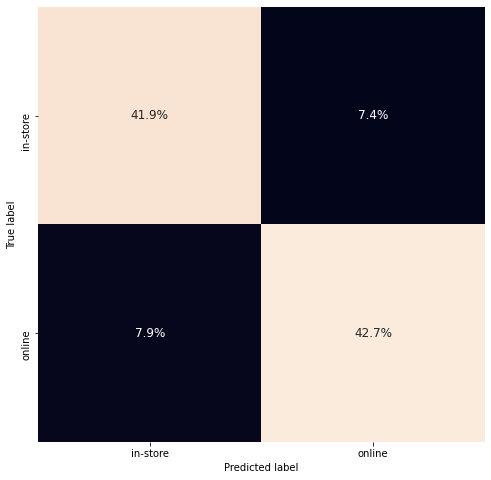

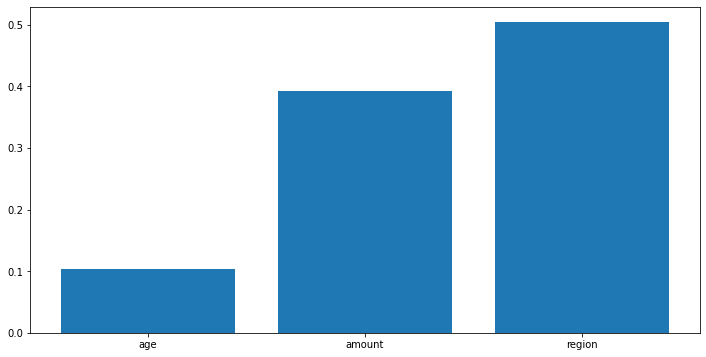

In [80]:
model = DecisionTreeClassifier()
fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(12,6))
plt.bar(feats,model.feature_importances_)
plt.show()

[18:09:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

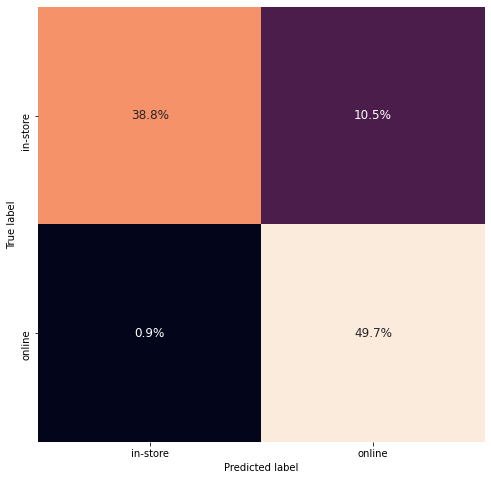

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

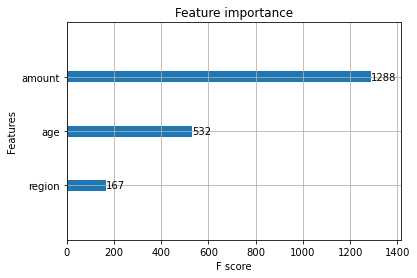

In [81]:
model = xgb.XGBClassifier(use_label_encoder=False)
fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, labels, labels)
xgb.plot_importance(model)

Cross Validation accuracy scores: [0.85414236 0.84730788 0.84647441 0.85364227 0.85328443 0.85128376
 0.85645215 0.84911637 0.84794932 0.84994998]
Cross Validation accuracy: 0.851 +/- 0.003
Accuracy: 85 %
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      9870
           1       0.85      0.85      0.85     10125

    accuracy                           0.85     19995
   macro avg       0.85      0.85      0.85     19995
weighted avg       0.85      0.85      0.85     19995



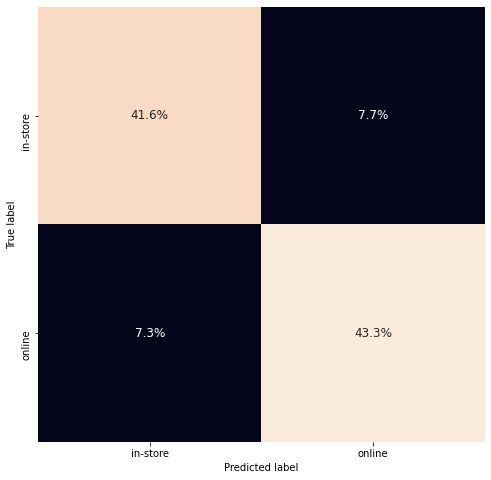

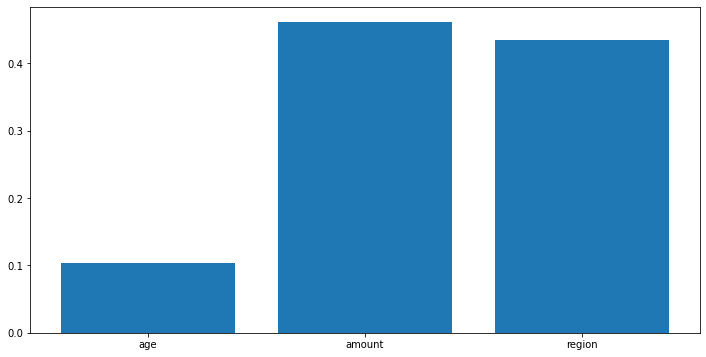

In [82]:
model = RandomForestClassifier()
fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(12,6))
plt.bar(feats,model.feature_importances_)
plt.show()

Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



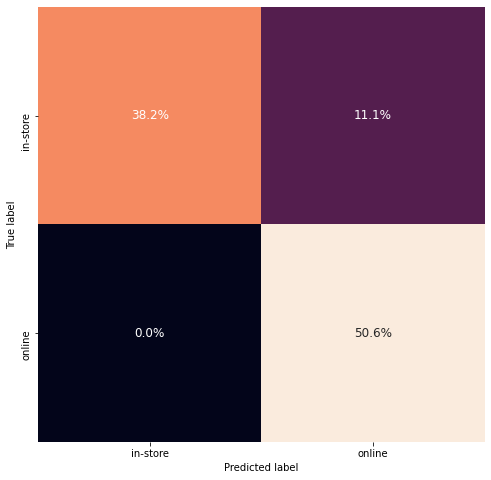

In [83]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}
fit_predict_plot_GS(DecisionTreeClassifier(), X_train, X_test, y_train, y_test, labels, labels, tree_para)

In [67]:
def XGBoost_fit_predict_CV(X_train, X_test, y_train, y_test):
    param_grid_cxgb = params = {
        'min_child_weight': [1, 5, 10, 20, 30],
        'gamma': [0.3, 0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.6, 0.8, 1.0, 1.5, 2.0],
        'max_depth': [3, 4, 5, 6, 8, 10]
        }
    eval_s = [(X_train_val, y_train_val),(X_val,y_val)]
    cxgb_reg = xgb.XGBClassifier(learning_rate=0.08, n_estimators=300, objective='binary:logistic',
                        silent=True, nthread=1, use_label_encoder=False);
    cxgb = RandomizedSearchCV(cxgb_reg, param_grid_cxgb, cv=5, scoring='recall',verbose=3);
    cxgb.fit(X_train_val, y_train_val,eval_set=eval_s, early_stopping_rounds=20)
    print(cxgb.best_params_)
    print(cxgb.best_estimator_)
    xgb_res = cxgb.cv_results_
    xgb_best = cxgb.best_estimator_
    results = xgb_best.evals_result()
    plt.figure()
    plt.plot(results['validation_0']['logloss'], label='train')
    plt.plot(results['validation_1']['logloss'], label='test')
    plt.legend(['Train set', 'Validation set'])
    plt.xlabel('Epoch')
    plt.ylabel('Classification Error')
    plt.show()
    y_pred = xgb_best.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=['In-store','Online'], yticklabels=['In-store','Online'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    plt.figure()
    xgb.plot_importance(xgb_best)
    plt.show()
    return round(accuracy_score(y_test, y_pred)*100), cxgb.best_estimator_

In [68]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=123)

In [ ]:
acc, best_est = XGBoost_fit_predict_CV(X_train, X_test, y_train, y_test)

In [84]:
feats_sets = [['age', 'amount_normalized', 'region'],
              ['age_levels_5_mean', 'amount', 'region'], 
              ['age_levels_5_mean', 'amount_levels_5_mean', 'region'], 
              ['age', 'amount_levels_5_mean', 'region'], 
              ['age', 'Region_2', 'Region_3', 'Region_4', 'amount_normalized'], 
              ['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount'], 
              ['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount_levels_5_mean']]
results_feats = {}


In [ ]:
for i, feats in enumerate(feats_sets):
    X = data[feats]
    y = data['in-store']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=123)
    accuracy, best_model = XGBoost_fit_predict_CV(X_train, X_test, y_train, y_test)
    results_feats[i] = {'feats':feats, 'accuracy':accuracy, 'best_model':best_model}
    

In [86]:
def fit_predict_plot_GS_acc(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels, params):
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    return round(accuracy_score(y_test, y_pred)*100), clf.best_params_

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



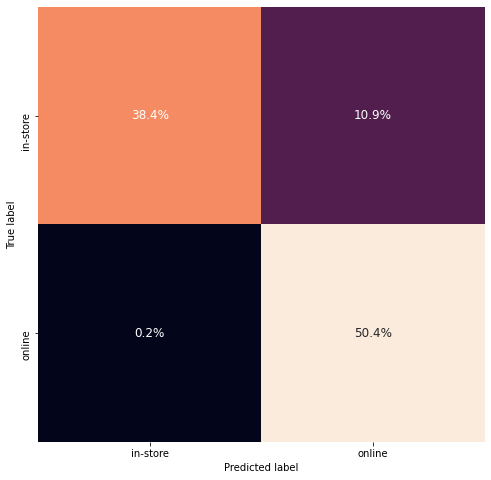

Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



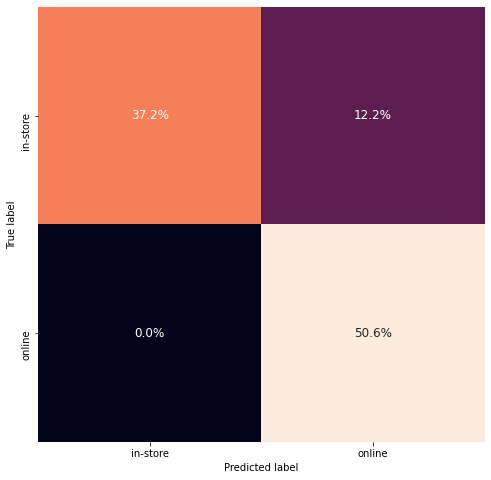

Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



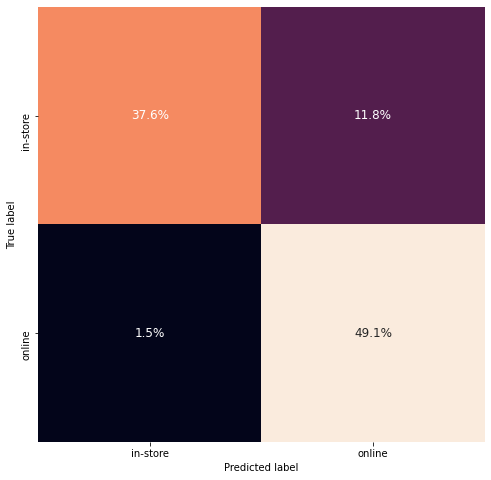

Accuracy: 88 %
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      9870
           1       0.82      0.96      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.89      0.88      0.88     19995
weighted avg       0.89      0.88      0.88     19995



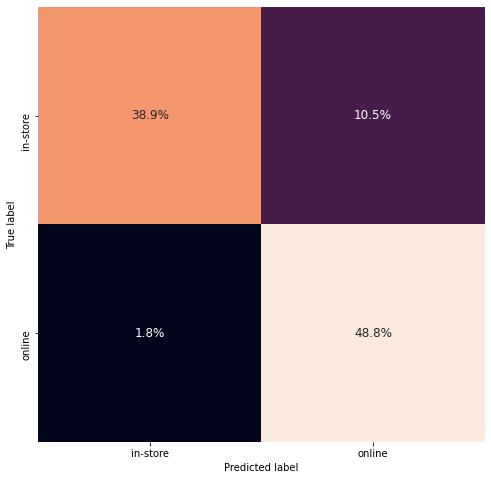

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      0.99      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



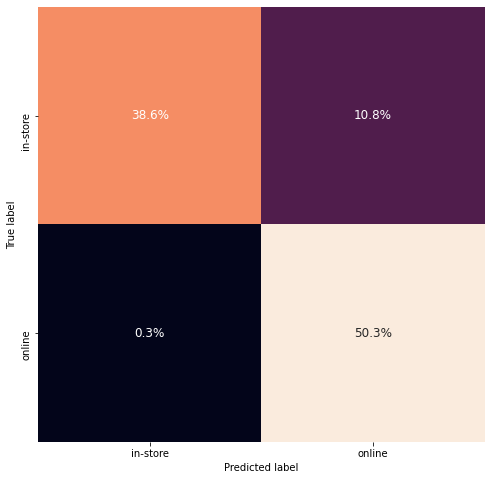

Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



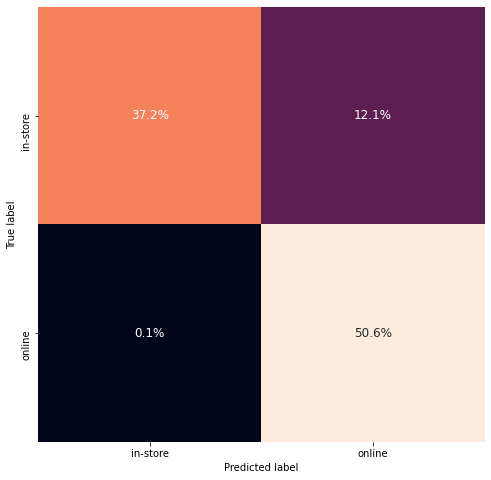

Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



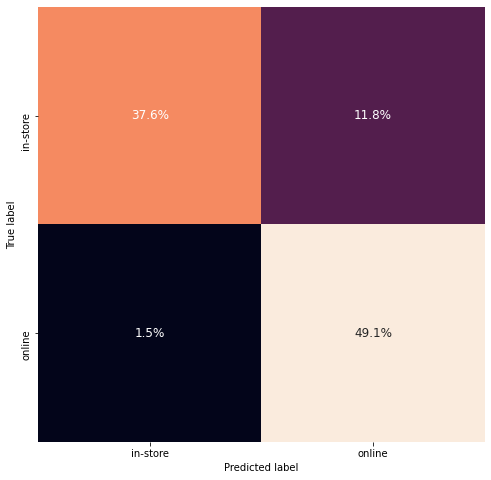

In [87]:
results_feats = {}
tree_para = {'criterion':['gini','entropy'],'max_depth':[2,3,4,5,6,7,8, 10,20]}

for i, feats in enumerate(feats_sets):
    X = data[feats]
    y = data['in-store']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
    model = DecisionTreeClassifier()
    accuracy, best_params = fit_predict_plot_GS_acc(model, X_train, X_test, y_train, y_test, labels, labels, tree_para)
    results_feats[i] = {'feats':feats, 'accuracy':accuracy, 'best_model': best_params}

Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



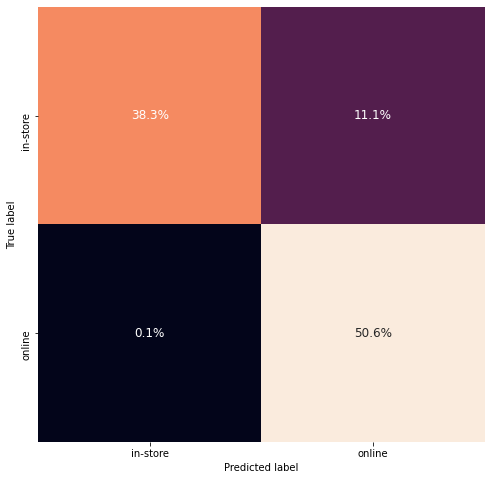

['age', 'amount_normalized', 'region']
Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



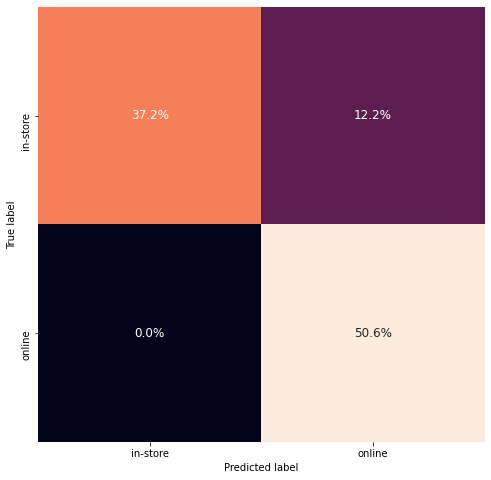

['age_levels_5_mean', 'amount', 'region']
Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



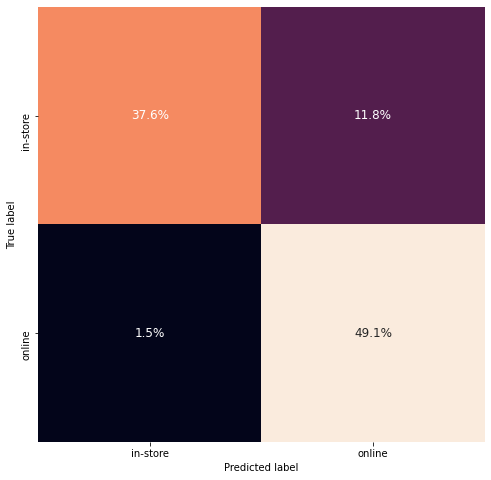

['age_levels_5_mean', 'amount_levels_5_mean', 'region']
Accuracy: 88 %
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      9870
           1       0.82      0.96      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.89      0.88      0.87     19995
weighted avg       0.89      0.88      0.88     19995



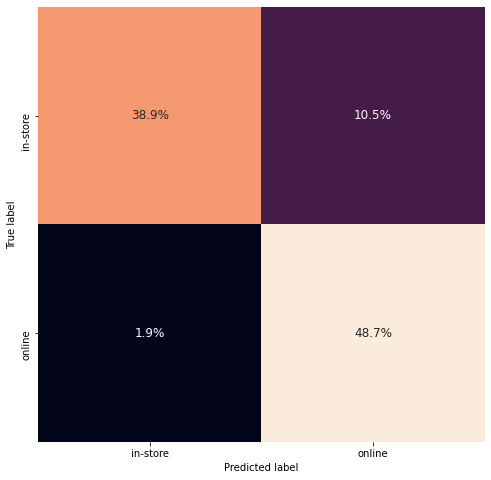

['age', 'amount_levels_5_mean', 'region']
Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



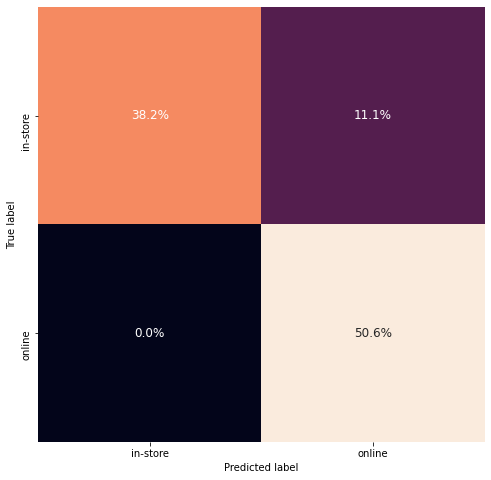

['age', 'Region_2', 'Region_3', 'Region_4', 'amount_normalized']
Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



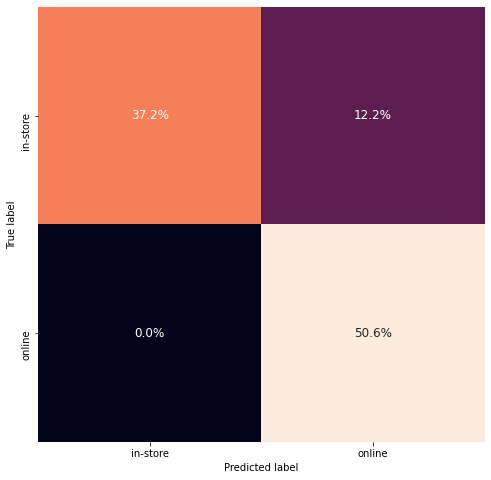

['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount']
Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



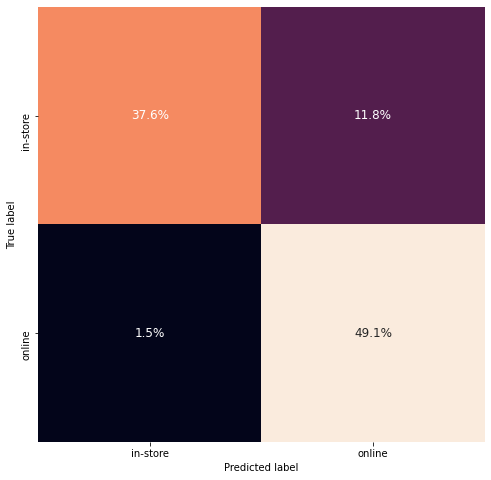

['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount_levels_5_mean']


In [90]:
results_feats = {}
tree_para = {
 'max_depth': [3, 4, 5, 6, 9, None],
 'n_estimators': [100, 200, 400]}

for i, feats in enumerate(feats_sets):
    X = data[feats]
    y = data['in-store']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
    model = RandomForestClassifier()
    accuracy, best_params = fit_predict_plot_GS_acc(model, X_train, X_test, y_train, y_test, labels, labels, tree_para)
    print(feats)
    results_feats[i] = {'feats':feats, 'accuracy':accuracy, 'best_model': best_params}

# Conclusions <a class="anchor" id="conclusions"></a>

### The dataset contained 21 duplicates which were removed but do not contain missing data. During the analysis of the collection, it was noticed that customers from the north only buy in-store, while customers from the south choose online shopping. Customers from other regions buy both online and in-store. There was no correlation between items and amount, but there were some relationships between other variables such as: age - in-store, region - items, region - age. Total number of items purchased online is same as total number of items purchased online, but customers spend more money during online shoping, because they choose more expensive products than in in-store shopping or it is effect of added shipping costs to amout of items. It may also be due to the higher price of products in the online store. In each age group, customers buy on average the same number of products per person, but younger peoples spend more money than older. Additional analyzes show that people older than 80 years old do not buy in-store, only people in their seventies bought more expensive products in-store than online, people from 30-60 years old spend more less the same in-store and online per one product and youngest people spend more per item online than in-store. Analyzes have shown that customers spend more online. Overall, there were large differences between regions. Both taking into account the type of purchases and the age groups of customers. Due to these differences, it would be necessary to carry out detailed analyzes for each of the regions separately. One example would be to find out why in the North and South regions customers only shop in-store or only online. This may be due to the lack of availability of another purchasing method. Another issue to be clarified could be the shipping cost included in the amount of online purchases (the question is whether it is added, how much is it, etc.), and then preparing the data without shipping costs. 

### Many experiments have been carried out with the model's hyperparameters and with the use of various features, but it did not bring any significant improvement. Also, applying the encoder to the region feature did not increase the efficiency of the model. However, this allows the variable to be treated as categorical but nominal. The conducted tests show that we are not able to correctly predict the age of the client based on demographic data. However, it is possible to predict whether the customer will buy online or in-store with an efficiency of 89%. The models show the same effectiveness on training and test data, which means that there was no overfitting phenomenon and the models can be used to predict new data. Region and amount spent are of the greatest importance in predicting this. The number of items purchased is of low importance. Variable bining has no influence on the achieved efficacy value.

 |Features | Target | Classifier | Hyperparams. | Accuracy |
 |:------|------|------|------|------|
 |Region | Age (7 bins) | DecisionTree| Default | 25% |
 |Region | Age (7 bins) | XBG | Default | 25% |
 |Region | Age (3 bins) | DecisionTree | Default | 47% |
 |Region | Age (3 bins) | XBG| Default | 47% |
 |Region,In-store, Amount, Items | Age (3 bins) | DecisionTree | Default | 43% |
 |Region,In-store, Amount, Items | Age (3 bins) | XBG | Default | 47% |
 |Age (7 bins) | In-store | DecisionTree | max_depth=4 | 59% |
 |Age (7 bins)  | In-store | XBG | Default | 59% |
 |Age, Items, Amount, Region, Age (7 bins), Amount per item, Age (3 bins) | In-store | DecisionTree | default | 84% |
 |Age, Items, Amount, Region, Age (7 bins), Amount per item, Age (3 bins)  | In-store | XBG | Default | 88% |
 |Age, Amount, Region | In-store | DecisionTree | Default | 84% |
 |Age, Amount, Region | In-store | DecisionTree | criterion=gini, max_depth=8| 84% |
 |Age, Amount, Region | In-store | XBG | Default | 89% |
 |Age, Amount, Region | In-store | RandomForest | Default | 85% |
 |Age, Amount normalized, Region | In-store | DecisionTree | criterion=entropy, max_depth=10| 89% |
 |Age (3 bins), Amount (5 bins), Region (One hot encoded) | In-store | DecisionTree | criterion=gini, max_depth=8| 89% |
 |Age, Amount normalized, Region | In-store | XGB | n_estimators=300, booster='gbtree', max_depth=5| 89% |
 |Age (3 bins), Amount (5 bins), Region (One hot encoded) | In-store | XGB | n_estimators=300, booster='gbtree', max_depth=3 | 89% |
 |Age (5 bins), Amount, Region | In-store | RandomForest |n_estimators=200, max_depth=5  | 87% |
 |Age (5 bins), Amount, Region (One hot encoded)| In-store | RandomForest |n_estimators=400, max_depth=3 | 88% |